In [20]:
import torch
from torch import nn
import numpy as np
from torchvision.utils import save_image

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 1. Dataset

In [21]:
import torchvision

img_size = 32
num_classes = 10

In [22]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((img_size, img_size)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5], std=[0.5])
])

mnist_images = torchvision.datasets.MNIST(root='mnist_data', train=True, 
                                    download=True, transform=transform)

In [23]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
dataloader = DataLoader(mnist_images, batch_size=BATCH_SIZE, shuffle=True)

# 2. Model

In [24]:
channels = 1
img_shape = (channels, img_size, img_size)
latent_dim = 100

In [25]:
emb_dim=16
label_emb = nn.Embedding(num_classes, emb_dim, _freeze=True) 
label_emb.to(device)

Embedding(10, 16)

In [26]:
class Generator(nn.Module):
    def __init__(self, num_classes, emb_dim):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(latent_dim + emb_dim, 256),
            nn.BatchNorm1d(256,),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2, inplace=True),
        
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )
        
    def forward(self, z, label):
        cond = label_emb(label)
        x = torch.cat([z, cond], 1)
        img = self.model(x)
        img = img.view(img.size(0), *img_shape)
        return img

In [27]:
class Descriminator(nn.Module):
    def __init__(self, num_classes, emb_dim):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape))+emb_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        
    def forward(self, img, label):
        img_flat = img.view(img.size(0), -1)
        cond = label_emb(label)
        x = torch.cat([img_flat, cond], 1)
        validity = self.model(x)
        return validity

In [28]:
generator = Generator(num_classes=num_classes, emb_dim=16)
discriminator = Descriminator(num_classes=num_classes, emb_dim=16)

In [29]:
generator.to(device)

Generator(
  (model): Sequential(
    (0): Linear(in_features=116, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=512, out_features=1024, bias=True)
    (7): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Linear(in_features=1024, out_features=1024, bias=True)
    (10): Tanh()
  )
)

In [30]:
discriminator.to(device)

Descriminator(
  (model): Sequential(
    (0): Linear(in_features=1040, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

# 3. Training

In [31]:
import os
os.makedirs("images_cGAN_fv", exist_ok=True)

save_interval = 10

In [32]:
EPOCHS = 200

optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0001)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002)

criterion = nn.BCELoss()
hist = {
        "train_G_loss": [],
        "train_D_loss": [],
}

In [33]:
for epoch in range(EPOCHS):
    running_G_loss = 0.0
    running_D_loss = 0.0

    for i, (imgs, labels) in enumerate(dataloader):
        real_imgs = imgs.to(device)
        labels = labels.to(device)
        
        real_labels = torch.ones((imgs.shape[0], 1)).to(device)
        fake_labels = torch.zeros((imgs.shape[0], 1)).to(device)


        # -------------------------- Train Generator --- 
        optimizer_G.zero_grad()
        
        # Noise input for Generator
        z = torch.randn((imgs.shape[0], latent_dim)).to(device)

        gen_imgs = generator(z, labels)
        validity = discriminator(gen_imgs, labels)
        G_loss = criterion(validity, real_labels)
        running_G_loss += G_loss.item()

        G_loss.backward()
        optimizer_G.step()


        # -------------- Train Discriminator --- 
        optimizer_D.zero_grad()

        real_validity = discriminator(real_imgs, labels)
        real_loss = criterion(real_validity, real_labels)

        fake_validity = discriminator(gen_imgs.detach(), labels)
        fake_loss = criterion(fake_validity, fake_labels)
        
        D_loss = (real_loss + fake_loss) / 2
        running_D_loss += D_loss.item()

        D_loss.backward()
        optimizer_D.step()
    
    epoch_G_loss = running_G_loss / len(dataloader)
    epoch_D_loss = running_D_loss / len(dataloader)
    
    print(f"Epoch [{epoch + 1}/{EPOCHS}], Train G Loss: {epoch_G_loss:.4f}, Train D Loss: {epoch_D_loss:.4f}")

    hist["train_G_loss"].append(epoch_G_loss)
    hist["train_D_loss"].append(epoch_D_loss)

    if epoch % save_interval == 0:
        save_image(gen_imgs.data[:25], f"images_cGAN_fv/epoch_{epoch}.png", nrow=5, normalize=True)

Epoch [1/200], Train G Loss: 10.8335, Train D Loss: 0.0862
Epoch [2/200], Train G Loss: 18.5222, Train D Loss: 0.0917
Epoch [3/200], Train G Loss: 12.9979, Train D Loss: 0.1568
Epoch [4/200], Train G Loss: 4.1196, Train D Loss: 0.1817
Epoch [5/200], Train G Loss: 4.2053, Train D Loss: 0.1625
Epoch [6/200], Train G Loss: 3.8913, Train D Loss: 0.1617
Epoch [7/200], Train G Loss: 4.0116, Train D Loss: 0.1650
Epoch [8/200], Train G Loss: 4.2292, Train D Loss: 0.1540
Epoch [9/200], Train G Loss: 4.0559, Train D Loss: 0.1569
Epoch [10/200], Train G Loss: 4.0142, Train D Loss: 0.1481
Epoch [11/200], Train G Loss: 4.0232, Train D Loss: 0.1550
Epoch [12/200], Train G Loss: 4.0708, Train D Loss: 0.1501
Epoch [13/200], Train G Loss: 4.0389, Train D Loss: 0.1585
Epoch [14/200], Train G Loss: 3.8080, Train D Loss: 0.1795
Epoch [15/200], Train G Loss: 3.8455, Train D Loss: 0.1769
Epoch [16/200], Train G Loss: 3.6926, Train D Loss: 0.1839
Epoch [17/200], Train G Loss: 3.7912, Train D Loss: 0.1921
Epo

# 4. Inference

In [34]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

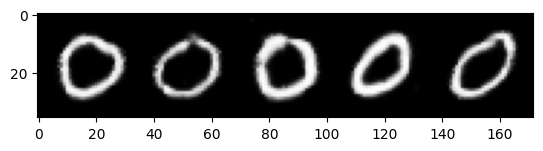

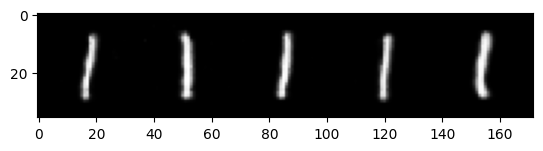

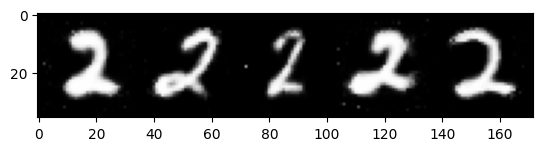

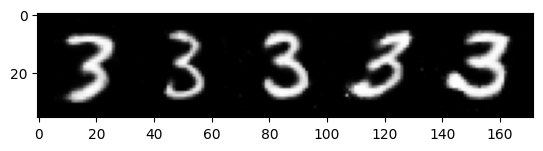

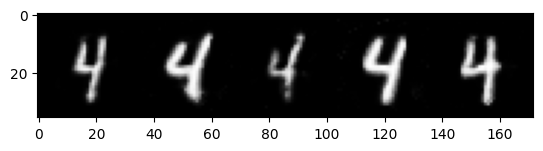

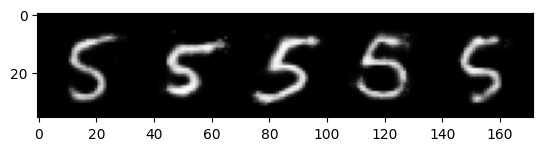

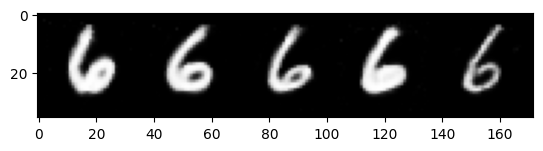

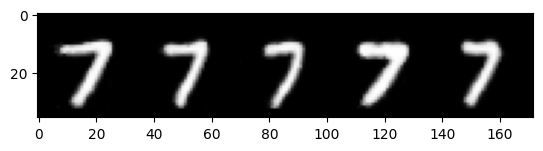

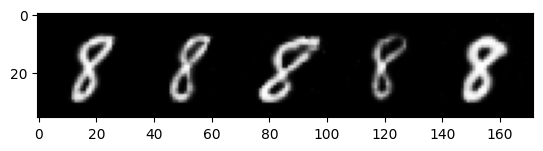

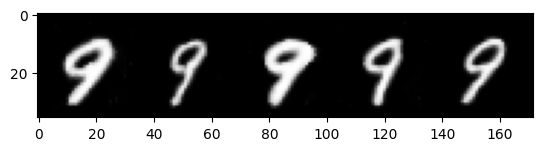

In [35]:
generator.eval()

num_sample = 5
for i in range(num_classes):
    target_class = i
    z = torch.randn((num_sample, latent_dim)).to(device)
    condition_labels = torch.full((num_sample,), target_class, dtype=torch.long).to(device)

    gen_imgs = generator(z, condition_labels).detach().cpu()

    grid = make_grid(gen_imgs, nrow=num_sample, normalize=True).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.show()